In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Read CSV
df = pd.read_csv(r"D:\Aviation\InitialAttackConusData\FPA_FOD_Plus.csv")

# Display head
print(df.head())

# Create binary event_type column based on FIRE_SIZE_CLASS
#df['event_type'] = df['FIRE_SIZE_CLASS'].apply(lambda x: 1 if x in ['D', 'E', 'F', 'G'] else 0)
df['event_type'] = df.apply(
    lambda row: 1 if (row['Land_Cover'] in [52, 71, 81] and row['FIRE_SIZE_CLASS'] in ['E', 'F', 'G']) 
    or (row['Land_Cover'] not in [52, 71, 81] and row['FIRE_SIZE_CLASS'] in ['D', 'E', 'F', 'G']) 
    else 0,
    axis=1
)


In [ ]:
import pandas as pd

# Load FPA-FOD metadata
fpafod_df = df #pd.read_csv(r"D:\Aviation\2020_FPA_FOD_cons.csv")

# Load IMSR national activity
imsr_df = pd.read_csv(r"D:\Aviation\IMSR\national_activity.csv")

# Convert dates to datetime
fpafod_df['DISCOVERY_DATE'] = pd.to_datetime(fpafod_df['DISCOVERY_DATE'])
imsr_df['imsr_date'] = pd.to_datetime(imsr_df['imsr_date'])

# Sort both DataFrames by date for merge_asof
fpafod_df = fpafod_df.sort_values('DISCOVERY_DATE')
imsr_df = imsr_df.sort_values('imsr_date')

# Merge using nearest earlier IMSR report (backward fill)
merged_df = pd.merge_asof(
    fpafod_df,
    imsr_df,
    left_on='DISCOVERY_DATE',
    right_on='imsr_date',
    direction='backward'
)

# Calculate lag in days
merged_df['imsr_lag_days'] = (merged_df['DISCOVERY_DATE'] - merged_df['imsr_date']).dt.days
merged_df['event_binary'] = merged_df['event_type'].apply(lambda x: 1 if x != 0 else 0)

# Print stats
print("Number of unmatched DISCOVERY_DATEs after merge_asof:", merged_df['imsr_date'].isna().sum())
print("Lag (DISCOVERY_DATE - imsr_date) in days:")
print("  Min:", merged_df['imsr_lag_days'].min())
print("  Max:", merged_df['imsr_lag_days'].max())
print("  Mean:", merged_df['imsr_lag_days'].mean())
print(merged_df['GACCAbbrev'].value_counts())
print(len(merged_df))


# Identify rows where IMSR data did not merge (i.e., imsr_date is NaT)
unmatched = merged_df[merged_df['imsr_date'].isna()]
matched = merged_df[merged_df['imsr_date'].notna()]

# Print how many didn't merge and show a preview
print(f"Number of unmatched DISCOVERY_DATEs: {len(unmatched)}")
print(unmatched[['FPA_ID', 'DISCOVERY_DATE']].head(10))

#print(list(surv_merged.columns))

# Print date range of unmatched DISCOVERY_DATEs
if not unmatched.empty:
    print("Date range of unmatched DISCOVERY_DATEs:")
    print("  Min:", unmatched['DISCOVERY_DATE'].min())
    print("  Max:", unmatched['DISCOVERY_DATE'].max())
else:
    print("No unmatched DISCOVERY_DATEs found.")



# Convert 'initial_attack_activity' from strings to numeric codes
matched['initial_attack_activity'] = matched['initial_attack_activity'].map({
    'LIGHT': 0,
    'MODERATE': 1,
    'HEAVY': 2
})



In [ ]:
import pandas as pd

# Load and prepare resource summary
resource_df = pd.read_csv(r"D:\Aviation\IMSR\resource_summary.csv")
resource_df['imsr_date'] = pd.to_datetime(resource_df['imsr_date'])
resource_df.rename(columns={'gacc': 'GACCAbbrev'}, inplace=True)
print(resource_df['GACCAbbrev'].unique())
print(resource_df['GACCAbbrev'].value_counts())
print("Min imsr_date:", resource_df['imsr_date'].min())
print("Max imsr_date:", resource_df['imsr_date'].max())

# Standardize GACC codes
merged_df['GACCAbbrev'] = merged_df['GACCAbbrev'].str.upper().str.strip()
resource_df['GACCAbbrev'] = resource_df['GACCAbbrev'].str.upper().str.strip()

# Perform per-GACC asof‐merge and collect results
merged_parts = []
for gacc in merged_df['GACCAbbrev'].unique():
    fire_sub = (
        merged_df[merged_df['GACCAbbrev'] == gacc]
        .sort_values('DISCOVERY_DATE')
    )
    res_sub = (
        resource_df[resource_df['GACCAbbrev'] == gacc]
        .sort_values('imsr_date')
    )
    merged_res = pd.merge_asof(
        fire_sub,
        res_sub,
        by='GACCAbbrev',
        left_on='DISCOVERY_DATE',
        right_on='imsr_date',
        direction='backward',
        suffixes=('', '_resource')
    )
    merged_parts.append(merged_res)

# Combine all GACC parts back into one DataFrame
final_df = pd.concat(merged_parts, ignore_index=True)


# Add proportion columns for each variable relative to the sum across all GACCs on that day
vars_to_prop = [
    'incidents',
    'cumulative_size',
    'crews',
    'engines',
    'helicopters',
    'personnel',
    'personnel_change'
]
for col in vars_to_prop:
    final_df[f'{col}_prop'] = final_df[col] / final_df.groupby('DISCOVERY_DATE')[col].transform('sum')

print("Number of NaNs in 'crews':", final_df['crews'].isna().sum())
print("Number of non-NA in 'crews':", final_df['crews'].notna().sum())

final_df.dropna(subset=['crews'], inplace=True)

final_df

In [ ]:
# Load second resource CSV
resource_df2 = pd.read_csv(r"D:\Aviation\IMSR\gacc_activity.csv")
resource_df2['imsr_date'] = pd.to_datetime(resource_df2['imsr_date'])
resource_df2.rename(columns={'gacc': 'GACCAbbrev'}, inplace=True)
resource_df2['GACCAbbrev'] = resource_df2['GACCAbbrev'].str.upper().str.strip()

# Perform per-GACC asof-merge with new resource_df2
merged_parts2 = []
for gacc in final_df['GACCAbbrev'].unique():
    fire_sub = (
        final_df[final_df['GACCAbbrev'] == gacc]
        .sort_values('DISCOVERY_DATE')
    )
    res_sub = (
        resource_df2[resource_df2['GACCAbbrev'] == gacc]
        .sort_values('imsr_date')
    )
    merged_res = pd.merge_asof(
        fire_sub,
        res_sub,
        by='GACCAbbrev',
        left_on='DISCOVERY_DATE',
        right_on='imsr_date',
        direction='backward',
        suffixes=('', '_activity')
    )
    merged_parts2.append(merged_res)

# Final combined DataFrame with both resource summaries added
final_df = pd.concat(merged_parts2, ignore_index=True)


In [ ]:
print(final_df['area_command_teams_activity'].value_counts(dropna=False))


In [ ]:
#final_df.to_csv(r"D:\Aviation\IMSR\final_df_resource_summary_AND_gacc_activity_AND_national_activity_2015_20212.csv", index=False)

In [ ]:
# final_df.dropna(subset=['crews'], inplace=True)
# final_df

In [ ]:

print(list(matched.columns))


In [ ]:
import geopandas as gpd
import rasterio
from shapely.geometry import Point, shape
from rasterio.enums import Resampling
from rasterio.features import shapes
import numpy as np
from tqdm import tqdm
import pandas as pd

# https://www.epa.gov/ground-water-and-drinking-water/community-water-system-service-area-boundaries?tab=map
final_df = pd.read_csv(r"D:\Aviation\IMSR\final_df_resource_summary_AND_gacc_activity_AND_national_activity_2015_2021.csv")
matched = final_df

# --- Paths ---
#water_shp = r"D:\Aviation\NHD_H_California_State_Shape\Shape\NHDWaterbody.shp"
water_shp = r"C:\Users\magst\OneDrive\Pictures\Desktop\Aviation\OTHERshp\EPA_CommunityWaterSystemServiceAreaBoundaries.shp"
trans_shp = r"D:\Aviation\Transmission_Lines\Transmission_Lines.shp"
raster_path = r"D:\Aviation\CONUS_corridors_opportunity_nondeducted.tif"

# --- Load vector layers ---
water_gdf = gpd.read_file(water_shp).to_crs(epsg=3310)
trans_gdf = gpd.read_file(trans_shp).to_crs(epsg=3310)

# --- Convert matched to GeoDataFrame ---
matched_gdf = matched.dropna(subset=['LATITUDE', 'LONGITUDE']).copy()
matched_gdf['geometry'] = [Point(xy) for xy in zip(matched_gdf['LONGITUDE'], matched_gdf['LATITUDE'])]
matched_gdf = gpd.GeoDataFrame(matched_gdf, geometry='geometry', crs='EPSG:4326').to_crs(epsg=3310)

# --- Create spatial indexes ---
water_sindex = water_gdf.sindex
trans_sindex = trans_gdf.sindex

# --- Function to compute nearest distance and flag ---
def compute_nearest_and_flag(pt, target_gdf, target_sindex):
    buffer_bounds = pt.buffer(100000).bounds
    candidate_idx = list(target_sindex.intersection(buffer_bounds))
    
    if candidate_idx:
        candidates = target_gdf.iloc[candidate_idx]
        nearest_geom = candidates.distance(pt).sort_values().index[0]
        nearest_distance = pt.distance(target_gdf.loc[nearest_geom].geometry)
    else:
        nearest_distance = float("inf")
    
    return nearest_distance, int(nearest_distance <= 5000)

# --- Compute water and transmission line distances ---
dist_to_water, has_water = [], []
dist_to_trans, has_trans = [], []

for pt in tqdm(matched_gdf.geometry, desc="Processing water & transline"):
    d_water, f_water = compute_nearest_and_flag(pt, water_gdf, water_sindex)
    d_trans, f_trans = compute_nearest_and_flag(pt, trans_gdf, trans_sindex)
    
    dist_to_water.append(d_water)
    has_water.append(f_water)
    dist_to_trans.append(d_trans)
    has_trans.append(f_trans)

matched_gdf['dist_to_water_m'] = dist_to_water
matched_gdf['has_water_within_5km'] = has_water
matched_gdf['dist_to_transline_m'] = dist_to_trans
matched_gdf['has_transline_within_5km'] = has_trans

# --- Reproject matched points to raster CRS ---
with rasterio.open(raster_path) as src:
    raster_crs = src.crs
    raster_transform = src.transform

    # Downsample
    scale = 4
    new_height = src.height // scale
    new_width = src.width // scale

    data = src.read(1, out_shape=(1, new_height, new_width), resampling=Resampling.nearest)
    new_transform = src.transform * src.transform.scale(src.width / new_width, src.height / new_height)

# --- Vectorize raster mask ---
mask = data > 0
corridor_shapes = list(shapes(data.astype("uint8"), mask=mask, transform=new_transform))
corridor_geoms = [shape(geom) for geom, val in corridor_shapes if val == 1]
corridor_gdf = gpd.GeoDataFrame(geometry=corridor_geoms, crs=raster_crs)
corr_sindex = corridor_gdf.sindex

# --- Reproject matched_gdf to raster CRS ---
matched_corr = matched_gdf.to_crs(raster_crs)

# --- Compute distances to corridor ---
dist_to_corridor = []

for pt in tqdm(matched_corr.geometry, desc="Computing distances to corridors"):
    buffer_bounds = pt.buffer(100000).bounds
    candidate_idx = list(corr_sindex.intersection(buffer_bounds))
    
    if candidate_idx:
        candidates = corridor_gdf.iloc[candidate_idx]
        nearest_distance = candidates.distance(pt).min()
    else:
        nearest_distance = float("inf")
    
    dist_to_corridor.append(nearest_distance)

matched_gdf['dist_to_corridor_m'] = dist_to_corridor

# --- Reproject back and update matched ---
matched_gdf = matched_gdf.to_crs(epsg=4326)
matched.loc[matched_gdf.index, 'dist_to_water_m'] = matched_gdf['dist_to_water_m']
matched.loc[matched_gdf.index, 'has_water_within_5km'] = matched_gdf['has_water_within_5km']
matched.loc[matched_gdf.index, 'dist_to_transline_m'] = matched_gdf['dist_to_transline_m']
matched.loc[matched_gdf.index, 'has_transline_within_5km'] = matched_gdf['has_transline_within_5km']
matched.loc[matched_gdf.index, 'dist_to_corridor_m'] = matched_gdf['dist_to_corridor_m']
# Ran 7_8_2025

In [ ]:
#matched.to_csv(r"D:\Aviation\InitialAttackConusData\matched_with_features_7_7.csv", index=False)
matched.to_csv(r"D:\Aviation\IMSR\final_df_resource_summary_AND_gacc_activity_AND_national_activity_2015_2021_WITH_water_lines_cooridors.csv", index=False)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Count infs in distance columns ---
distance_cols = ['dist_to_water_m', 'dist_to_transline_m', 'dist_to_corridor_m']

for col in distance_cols:
    inf_count = np.isinf(matched[col]).sum()
    print(f"{col}: {inf_count} values are inf")

# --- Add flag for any inf ---
matched['has_inf'] = matched[distance_cols].apply(lambda row: any(np.isinf(row)), axis=1)

# --- Plot ---
plt.figure(figsize=(10, 8))
plt.scatter(matched['LONGITUDE'], matched['LATITUDE'], 
            c=matched['has_inf'].map({True: 'red', False: 'blue'}),
            s=1, alpha=0.6, label='Points')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Matched Points: Red = Has Inf Distance')
plt.grid(True)
plt.legend(['Has Inf'])
plt.tight_layout()
plt.show()


In [ ]:
# START HERE

In [2]:
# import pandas as pd

# # Read the CSV
# df = pd.read_csv(r"D:\Aviation\IMSR\final_df_resource_summary_AND_gacc_activity_AND_national_activity_2015_2021_WITH_water_lines_cooridors.csv")

# # Print column names
# print(df.columns.tolist())
import pandas as pd

# Read the CSV
df = pd.read_csv(r"D:\Aviation\IMSR\final_df_resource_summary_AND_gacc_activity_AND_national_activity_2015_2021_WITH_water_lines_cooridors.csv")

# Print column names
#print(df.columns.tolist())

df = df[
    (df['RPL_THEMES'] != -999) &
    (df['EPL_MUNIT'] != -999)
]

mapping = {'LIGHT': 0, 'MODERATE': 1, 'HEAVY': 2}
df['initial_attack_activity'] = df['initial_attack_activity'].map(mapping)



matched = df

import numpy as np
# Define variable sets
hazard_vars = [
    'vpd_Normal', 'bi_Normal', 'fm100_Normal',
    'srad_Normal', 'sph_Normal', 'Slope', 'TRI', 'TPI', 'Elevation',
    'erc', 'vs', 'Aridity_index', 'SDI'
]

values_vars = [
    'Popo_1km', 'GHM', 'RPL_THEMES', 'EPL_MUNIT', 'dist_to_water_m', 'dist_to_transline_m'
]

capacity_vars = [
    'NPL', 'GACC_PL', 'new_large_fires', 'type_2_teams',
    'type_1_teams', 'nimos', 'initial_attack_activity', 'engines', 'helicopters', 'crews'
]

predictors = hazard_vars + values_vars + capacity_vars


# # Define placeholder values and problematic columns
# placeholder_vals = [-999, -999.0, -3.402823e+38]
# problem_columns = ['SDI', 'GHM', 'RPL_THEMES', 'EPL_MUNIT']

# # Print length before cleaning
# print(f"Original matched length: {len(matched)}")

# # Replace known placeholder values with NaN
# for col in problem_columns:
#     matched[col] = matched[col].replace(placeholder_vals, np.nan)

print(len(matched))

# Drop rows where SDI or GHM are < 0
#matched = matched[(matched['SDI'] > 0) & (matched['GHM'] > 0)]

matched['SDI'] = matched['SDI'].where(matched['SDI'] >= 0, 0)
matched['GHM'] = matched['GHM'].where(matched['GHM'] >= 0, 0)

# Drop rows with missing predictor or target values
matched_clean = matched.dropna(subset=predictors + ['event_type'])

# Print length after cleaning
print(f"Cleaned matched_clean length: {len(matched_clean)}")

# Print unique event_type values and their counts
event_counts = matched_clean['event_type'].value_counts()
print("Event type counts:")
print(event_counts)

# Print number of unique event types
print(f"\nNumber of unique event types: {matched_clean['event_type'].nunique()}")



C:\Users\magst\AppData\Local\Temp\ipykernel_11588\1206654911.py:11: DtypeWarning: Columns (14,15,16,17,311) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"D:\Aviation\IMSR\final_df_resource_summary_AND_gacc_activity_AND_national_activity_2015_2021_WITH_water_lines_cooridors.csv")


455960
Cleaned matched_clean length: 445107
Event type counts:
event_type
0    435433
1      9674
Name: count, dtype: int64

Number of unique event types: 2


In [ ]:

# matched = df

# import numpy as np
# # Define variable sets
# hazard_vars = [
#     'vpd_Normal', 'bi_Normal', 'fm100_Normal',
#     'srad_Normal', 'sph_Normal', 'Slope', 'TRI', 'TPI', 'Elevation',
#     'erc', 'vs', 'Aridity_index', 'SDI'
# ]

# values_vars = [
#     'Popo_1km', 'GHM', 'RPL_THEMES', 'EPL_MUNIT', 'dist_to_water_m', 'dist_to_transline_m'
# ]

# capacity_vars = [
#     'NPL', 'GACC_PL', 'new_large_fires', 'type_2_teams',
#     'type_1_teams', 'nimos', 'initial_attack_activity', 'engines', 'helicopters', 'crews'
# ]


# predictors = hazard_vars + values_vars + capacity_vars


# # # Define placeholder values and problematic columns
# # placeholder_vals = [-999, -999.0, -3.402823e+38]
# # problem_columns = ['SDI', 'GHM', 'RPL_THEMES', 'EPL_MUNIT']

# # # Print length before cleaning
# # print(f"Original matched length: {len(matched)}")

# # # Replace known placeholder values with NaN
# # for col in problem_columns:
# #     matched[col] = matched[col].replace(placeholder_vals, np.nan)

# print(len(matched))

# # Drop rows where SDI or GHM are < 0
# #matched = matched[(matched['SDI'] > 0) & (matched['GHM'] > 0)]

# matched['SDI'] = matched['SDI'].where(matched['SDI'] >= 0, 0)
# matched['GHM'] = matched['GHM'].where(matched['GHM'] >= 0, 0)

# # Drop rows with missing predictor or target values
# matched_clean = matched.dropna(subset=predictors + ['event_type'])

# # Print length after cleaning
# print(f"Cleaned matched_clean length: {len(matched_clean)}")


In [ ]:
# # Basic structure
# print(matched_clean.info())

# # Summary stats for numeric columns
# print(matched_clean.describe())

# # Check for null values
# print(matched_clean.isnull().sum())


In [ ]:
# # Count where SDI < 0
# sdi_neg_count = (matched['SDI'] < 0).sum()
# print(f"Number of rows where SDI < 0: {sdi_neg_count}")

# # Count where GHM < 0
# ghm_neg_count = (matched['GHM'] < 0).sum()
# print(f"Number of rows where GHM < 0: {ghm_neg_count}")


In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Set style
# sns.set(style="whitegrid")

# # Histogram of SDI
# plt.figure(figsize=(10, 4))
# sns.histplot(matched_clean['crews'], bins=50, kde=True)
# plt.title("Distribution of SDI")
# plt.xlabel("SDI")
# plt.ylabel("Count")
# plt.tight_layout()
# plt.show()

# # Boxplot of SDI
# plt.figure(figsize=(8, 2))
# sns.boxplot(x=matched_clean['SDI'])
# plt.title("Boxplot of SDI")
# plt.tight_layout()
# plt.show()


In [ ]:
# matched_clean = matched_clean[
#     (matched_clean['RPL_THEMES'] != -999) &
#     (matched_clean['EPL_MUNIT'] != -999)
# ]

# mapping = {'LIGHT': 0, 'MODERATE': 1, 'HEAVY': 2}
# matched_clean['initial_attack_activity'] = matched_clean['initial_attack_activity'].map(mapping)


In [ ]:
# # Define variable sets
# hazard_vars = [
#     'vpd_Normal', 'bi_Normal', 'fm100_Normal',
#     'srad_Normal', 'sph_Normal', 'Slope', 'TRI', 'TPI', 'Elevation',
#     'erc', 'vs', 'Aridity_index', 'SDI'
# ]

# values_vars = [
#     'Popo_1km', 'GHM', 'RPL_THEMES', 'EPL_MUNIT'
# ]

# capacity_vars = [
#     'NPL', 'GACC_PL', 'new_large_fires', 'type_2_teams',
#     'type_1_teams', 'nimos', 'initial_attack_activity'
# ]
# import statsmodels.api as sm

# # Combine all predictor variables
# predictors = hazard_vars + values_vars + capacity_vars

# # Drop rows with missing values in predictors or target
# matched_clean = matched.dropna(subset=predictors + ['event_type'])

                                mean          std        min         25%  \
vpd_Normal                  1.122989     0.724370   0.050000    0.620000   
bi_Normal                  28.574939    14.227204   1.200000   18.700001   
fm100_Normal               13.526243     3.482786   2.500000   11.300000   
srad_Normal               223.583334    71.636138  36.000000  169.000000   
sph_Normal                  0.007019     0.003481   0.001100    0.004400   
Slope                       4.015598     5.832246   0.000000    1.000000   
TRI                         6.168165     8.451618   0.000000    1.732000   
TPI                         0.052892     1.146762 -26.625000   -0.375000   
Elevation                 572.519639   653.443550 -83.000000  111.000000   
erc                        43.727302    20.615368   0.000000   29.000000   
vs                          3.897819     1.646237   0.300000    2.700000   
Aridity_index               0.562302     0.355162   0.010000    0.240000   
SDI         

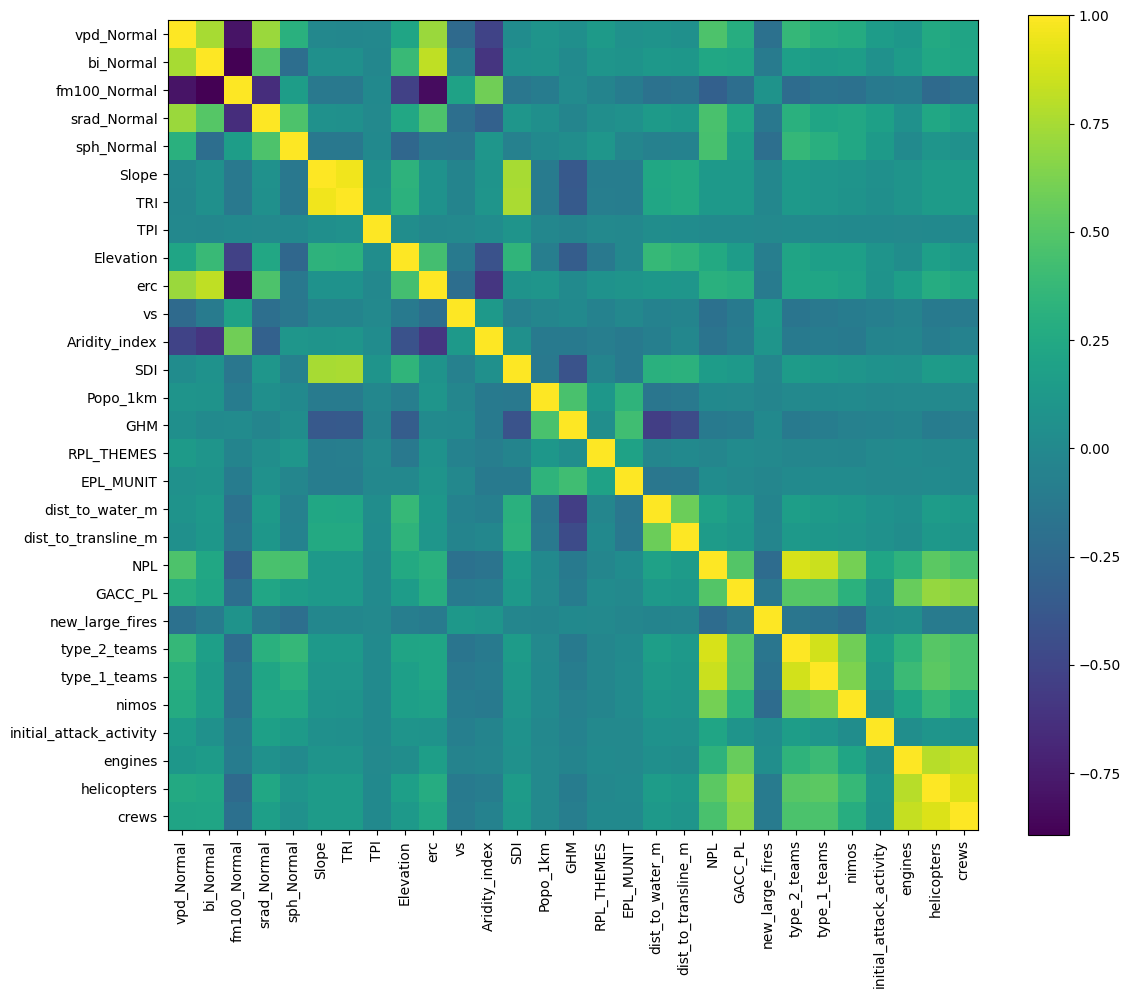

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# # Define predictor sets
# hazard_vars = [
#     'vpd_Normal', 'bi_Normal', 'fm100_Normal', 'srad_Normal', 'sph_Normal',
#     'Slope', 'TRI', 'TPI', 'Elevation', 'erc', 'vs', 'Aridity_index', 'SDI'
# ]
# values_vars = ['Popo_1km', 'GHM', 'RPL_THEMES', 'EPL_MUNIT']
# capacity_vars = [
#     'NPL', 'GACC_PL', 'new_large_fires', 'type_2_teams', 'type_1_teams',
#     'nimos', 'initial_attack_activity', 'engines', 'helicopters', 'crews'
# ]
# predictors = hazard_vars + values_vars + capacity_vars

# Descriptive statistics table
desc = matched_clean[predictors].describe().T[['mean', 'std', 'min', '25%', '50%', '75%', 'max']]
desc.to_csv('descriptive_stats_table.csv')
print(desc)

# Correlation matrix plot
corr = matched_clean[predictors].corr()
fig, ax = plt.subplots(figsize=(12, 10))
cax = ax.imshow(corr, interpolation='nearest')
ax.set_xticks(range(len(predictors)))
ax.set_yticks(range(len(predictors)))
ax.set_xticklabels(predictors, rotation=90)
ax.set_yticklabels(predictors)
fig.colorbar(cax)
plt.tight_layout()
plt.savefig('correlation_matrix.png')
plt.show()


In [ ]:
# # Count occurrences of -999 in the two columns
# count_rpl = (matched_clean['RPL_THEMES'] == -999).sum()
# count_epl = (matched_clean['EPL_MUNIT'] == -999).sum()

# print(f"RPL_THEMES == -999: {count_rpl}")
# print(f"EPL_MUNIT == -999: {count_epl}")


In [4]:
# see exactly what text values you have
print(matched_clean['initial_attack_activity'].unique())
print(matched_clean['EPL_MUNIT'].unique())

[0. 1. 2.]
[0.3048 0.6002 0.     ... 0.8374 0.6191 0.9421]


In [5]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# corr = matched_clean[predictors].corr()
# plt.figure(figsize=(12,10))
# sns.heatmap(corr, annot=False, cmap='coolwarm', center=0)

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

X_vif = sm.add_constant(matched_clean[predictors])
vif_data = pd.DataFrame()
vif_data['feature'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i)
                   for i in range(X_vif.shape[1])]

print(vif_data)


                    feature         VIF
0                     const  594.807961
1                vpd_Normal    8.338780
2                 bi_Normal    7.502734
3              fm100_Normal   16.651653
4               srad_Normal    4.978295
5                sph_Normal    5.743610
6                     Slope   13.328442
7                       TRI   13.604389
8                       TPI    1.011604
9                 Elevation    2.620271
10                      erc    4.038968
11                       vs    1.134553
12            Aridity_index    2.038260
13                      SDI    2.657901
14                 Popo_1km    1.355664
15                      GHM    2.379210
16               RPL_THEMES    1.158662
17                EPL_MUNIT    1.366323
18          dist_to_water_m    1.871136
19      dist_to_transline_m    1.631613
20                      NPL    8.121052
21                  GACC_PL    2.179608
22          new_large_fires    1.219570
23             type_2_teams    6.529617


In [ ]:
# from imblearn.over_sampling import SMOTE
# from sklearn.model_selection import train_test_split
# import statsmodels.api as sm
# from sklearn.metrics import roc_auc_score, f1_score, classification_report

# # --- Split predictors and target ---
# X = matched_clean[predictors]
# y = matched_clean['event_type']

# # --- Split into train/test (optional but recommended for generalization) ---
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# # --- Apply SMOTE to the training data ---
# smote = SMOTE(random_state=42)
# X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# # --- Add constant (intercept) ---
# X_train_res_const = sm.add_constant(X_train_res)
# X_test_const = sm.add_constant(X_test, has_constant='add')

# # --- Fit logistic regression ---
# logit_model = sm.Logit(y_train_res, X_train_res_const).fit(disp=False)

# # --- Predict on test set ---
# y_pred_proba = logit_model.predict(X_test_const)
# y_pred = (y_pred_proba > 0.5).astype(int)

# # --- Metrics ---
# auc = roc_auc_score(y_test, y_pred_proba)
# f1 = f1_score(y_test, y_pred)
# print(f"AUC: {auc:.4f}")
# print(f"F1-score: {f1:.4f}")
# print("\nClassification Report:\n", classification_report(y_test, y_pred))


In [6]:


# Define X and y
X = matched_clean[predictors]
X = sm.add_constant(X)  # add intercept
y = matched_clean['event_type']

# Fit logistic regression
logit_model = sm.Logit(y, X).fit(disp=False)

# Print summary
print(logit_model.summary())



from sklearn.metrics import roc_auc_score, f1_score, classification_report

# Get predicted probabilities and class labels
y_pred_proba = logit_model.predict(X)
y_pred = (y_pred_proba > 0.5).astype(int)  # threshold at 0.5

# Compute AUC and F1-score
auc = roc_auc_score(y, y_pred_proba)
f1 = f1_score(y, y_pred)

# Print results
print(f"AUC: {auc:.4f}")
print(f"F1-score: {f1:.4f}")

# Optional: full classification report
print("\nClassification Report:\n", classification_report(y, y_pred))



                           Logit Regression Results                           
Dep. Variable:             event_type   No. Observations:               445107
Model:                          Logit   Df Residuals:                   445077
Method:                           MLE   Df Model:                           29
Date:                Fri, 11 Jul 2025   Pseudo R-squ.:                  0.1251
Time:                        11:27:02   Log-Likelihood:                -40776.
converged:                       True   LL-Null:                       -46609.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -5.2839      0.262    -20.153      0.000      -5.798      -4.770
vpd_Normal                 -0.2515      0.042     -6.010      0.000      -0.334      -0.170


In [7]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, classification_report

# Prepare data
matched_clean = matched_clean.copy()  # ensure fresh copy
X = matched_clean[predictors]
y = matched_clean['event_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# 1) Statsmodels Logit
X_train_sm = sm.add_constant(X_train)
logit_train = sm.Logit(y_train, X_train_sm).fit(disp=False)
print(logit_train.summary())

X_test_sm = sm.add_constant(X_test)
y_proba = logit_train.predict(X_test_sm)
print("AUC (Logit):", roc_auc_score(y_test, y_proba))

best_t, best_f = 0, 0
for t in [i/100 for i in range(1,100)]:
    f = f1_score(y_test, (y_proba > t).astype(int))
    if f > best_f:
        best_f, best_t = f, t
print(f"Best threshold: {best_t}, F1: {best_f}")
print(classification_report(y_test, (y_proba > best_t).astype(int)))

# 2) Class-weighted Logistic Regression
lr = LogisticRegression(class_weight='balanced', max_iter=1000)
lr.fit(X_train, y_train)
y_proba_w = lr.predict_proba(X_test)[:,1]
print("AUC (class_weight LR):", roc_auc_score(y_test, y_proba_w))

best_t_w, best_f_w = 0, 0
for t in [i/100 for i in range(1,100)]:
    f = f1_score(y_test, (y_proba_w > t).astype(int))
    if f > best_f_w:
        best_f_w, best_t_w = f, t
print(f"Best threshold (weighted): {best_t_w}, F1: {best_f_w}")
print(classification_report(y_test, (y_proba_w > best_t_w).astype(int)))

# 3) Manual Undersampling
train_df = pd.concat([X_train, y_train], axis=1)
maj = train_df[train_df['event_type']==0]
minn = train_df[train_df['event_type']==1]
maj_down = maj.sample(n=len(minn), random_state=42)
balanced = pd.concat([maj_down, minn])
X_bal, y_bal = balanced[predictors], balanced['event_type']
lr2 = LogisticRegression(max_iter=1000)
lr2.fit(X_bal, y_bal)
y_proba_s = lr2.predict_proba(X_test)[:,1]
print("AUC (undersampled LR):", roc_auc_score(y_test, y_proba_s))

best_t_s, best_f_s = 0, 0
for t in [i/100 for i in range(1,100)]:
    f = f1_score(y_test, (y_proba_s > t).astype(int))
    if f > best_f_s:
        best_f_s, best_t_s = f, t
print(f"Best threshold (undersampled): {best_t_s}, F1: {best_f_s}")
print(classification_report(y_test, (y_proba_s > best_t_s).astype(int)))


                           Logit Regression Results                           
Dep. Variable:             event_type   No. Observations:               311574
Model:                          Logit   Df Residuals:                   311544
Method:                           MLE   Df Model:                           29
Date:                Fri, 11 Jul 2025   Pseudo R-squ.:                  0.1256
Time:                        11:27:21   Log-Likelihood:                -28529.
converged:                       True   LL-Null:                       -32627.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -5.5530      0.313    -17.751      0.000      -6.166      -4.940
vpd_Normal                 -0.2947      0.050     -5.869      0.000      -0.393      -0.196


C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC (class_weight LR): 0.7700212805277692
Best threshold (weighted): 0.7, F1: 0.12965912711054475
              precision    recall  f1-score   support

           0       0.98      0.93      0.96    130631
           1       0.08      0.28      0.13      2902

    accuracy                           0.92    133533
   macro avg       0.53      0.61      0.54    133533
weighted avg       0.96      0.92      0.94    133533



C:\Users\magst\anaconda3\envs\APPENV2\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AUC (undersampled LR): 0.767952503730488
Best threshold (undersampled): 0.74, F1: 0.13073370959466393
              precision    recall  f1-score   support

           0       0.98      0.95      0.97    130631
           1       0.09      0.22      0.13      2902

    accuracy                           0.94    133533
   macro avg       0.54      0.59      0.55    133533
weighted avg       0.96      0.94      0.95    133533



In [ ]:
# # 

# bad_vals = [-999, -999.0, -3.402823e+38]
# cols_to_fix = ['SDI', 'GHM', 'RPL_THEMES', 'EPL_MUNIT']

# for col in cols_to_fix:
#     matched[col] = matched[col].replace(bad_vals, np.nan)


# Compute summary statistics
summary_stats = X.describe().transpose()

# Display the summary
print(summary_stats)


In [ ]:
# NEURAL NETWORK

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np

# Prepare data
predictors = hazard_vars + values_vars + capacity_vars
matched_clean = matched.dropna(subset=predictors + ['event_type'])

X = matched_clean[predictors].values
y = matched_clean['event_type'].values

# Scale predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define neural network model (single-layer logistic regression equivalent)
model = Sequential([
    Dense(1, input_shape=(X_scaled.shape[1],), activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


from sklearn.utils import class_weight

# Compute class weights
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)
class_weights = {i: weights[i] for i in range(len(weights))}




# Fit model
model.fit(X_scaled, y, epochs=10, batch_size=512, verbose=1, class_weight=class_weights)

# Predict probabilities and binary outcomes
y_pred_proba = model.predict(X_scaled).flatten()
y_pred = (y_pred_proba > 0.5).astype(int)

# Evaluate
print(classification_report(y, y_pred))
print("AUC:", roc_auc_score(y, y_pred_proba))
